In [1]:
!pip3 install -q torch==2.0.1 torchvision torchaudio

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5d7ab28b-e710-3658-96fc-50af5a594817)


# 02. PyTorch Neural Network Classification

## What is a classification problem?

A classification problem involves predicting whether something is one thing or another.

For example, you might want to:

| Problem type | What is it? | Example |
| ------------ | ----------- | ------- |
| **Binary classification** | Target can be one of two options, e.g. yes o no | Predict whether or not someone has heart disease based on their health parameters. |
| **Multi-class classification** | Target can be one of more than two options | Decide whether a photo of is of food, a person or a dog. |
| **Multi-label classification** | Target can be assigned more than one option | Predict what categories should be assigned to a Wikipedia article (e.g. mathematics, science & philosophy). |

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-different-classification-problems.png)

Classification, along with regressino (predicting a number, covered in notebook 01) is one of the most common types of machine learning problems.

## What we're going to cover
In this notebook we're going to reiterate over the PyTorch workflow we coverd in torch_01_pytorch_workflow.

Specifically, we're going to cover:

| Topic | Contents |
| ----- | -------- |
| **0. Architecture of a classification neural network** | Neural networks can come in almost any shape or size, but they typically follow a similar floor plan. |
| **1. Getting binary classification data ready** | Data can be almost anything but to get started we're going to create a simple binary classification dataset. |
| **2. Building a PyTorch classification model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop** specific to classification. |
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |
| **5. Improving a model (from a model perspective)** | We've trained an evaluated a model but it's not working, let's try a few things to improve it. |
| **6. Non-linearity** | So far our model has only had the ability to model straight lines, what about non-linear (non-straight) lines? |
| **7. Replicating non-linear functions** | We used **non-linear functions** to help model non-linear data, but what do these look like? |
| **8. Putting it all together with multi-class classification** | Let's put everything we've done so far for binary classification together with a multi-class classification problem. |

## 0. Architecture of a classification neural network

Before we get into writing code, let's look at the general architecture of a classification neural network.

| Hyperparameter | Binary Classification | Multi-class Classification |
| -------------- | --------------------- | -------------------------- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking, status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, `minimum=1`, `maximum=unlimited` | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generaly `10 to 512` | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for foot, person or dog photo) |
| **Hidden layer activation** | Usually `ReLU` (rectified linear unit) but can be many others | Same as binary classification |
| **Output activation** | `Sigmoid` (`torch.sigmoid` in PyTorch) | `Softmax (`torch.softmax` in PyTorch) |
| **Loss function** | `Binary crossentropy (`torch.nn.BCELoss` in PyTorch) | Cross entropy (`torch.nn.CrossEntropyLoss` in PyTorch) |
| **Optimizer** | `SGD` (stochastic gradient descent), `Adam` (see `torch.optim` for more options) | Same as binary classification |

In [3]:
# Import important libraries
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split

## 1. Make classification data and get it ready

In [ ]:
# Make 1000 samples
n_samples = 1000

In [ ]:
# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,  # a little bit of nise to the dots
                    random_state=42)  # keep random state so we get the same values

In [ ]:
# View the first 5 `X` and `y` values
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [ ]:
# Make DataFrame of circle data
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "Label": y
                        })
circles.head(10)

,X1,X2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [ ]:
# Check different labels
circles.Label.value_counts()

1    500
0    500
Name: Label, dtype: int64

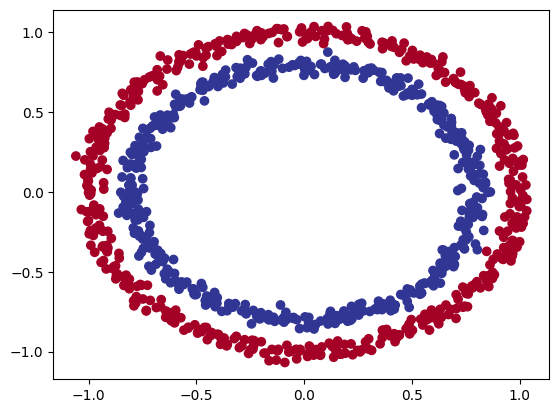

In [ ]:
# Visualise with a plot
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Input and output shapes

In [ ]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

Specifically, we'll need to:
1. Turn our data into tensors (right now our data is in NumPy arrays and PyTorch prefers to work with PyTorch tensors).
2. Split our data into training and test sets (we'll train a model on the training set to learn the patterns between `X` and `y` and then evaluate those learned patterns on the test dataset).

In [ ]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  # 20% test, 80% train
                                                    random_state=42)  # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

We'll break it donw into a few parts.
1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
2. Constructing a model by subclassing `nn.Module`.
3. Defining a loss function and optimizer.
4. Creating a training loop (this'll be in the next section).

In [ ]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

This setup where you have features and labels is referred to as **supervised learning**. Because your data is telling your model what the outputs should be given a certain input.

Let's create a model class that:
1. Subclass `nn.Module` (almost all PyTorch models are subclasses of `nn.Module`).
2. Create 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of `X` and `y`.
3. Defines a `forward()` method containing the forward pass computation of the model.
4. Instantiates the model class and send it to the target `device`.

In [ ]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5)  # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1)  # takes in 5 features, produces 1 feature (y)

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x))  # computation goes through layer_1
                                              # first then the output of layer_1
                                              # goes through layer_2

In [ ]:
# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

You can also do the same as above using `nn.Sequential`.

`nn.Sequential` performs a forward pass computation of the input data through the layers in the order they appear.

In [ ]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.2057],
        [-0.3587],
        [-0.0450],
        [-0.2503],
        [-0.4264],
        [-0.5168],
        [-0.6453],
        [-0.6833],
        [-0.0292],
        [-0.3732]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Table of various loss functions and optimizers, there are more but these some common ones you'll see.

| Loss function/Optimizer | Problem type | PyTorch code |
| ----------------------- | ------------ | ------------ |
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | `torch.optim.SGD()` |
| Adam Optimizer | Classification, regression, many others. | `torch.optim.Adam()` |
| Binary cross entropy loss | Binary classification | `torch.nn.BCELossWithLogits` or `toch.nn.BCELoss` |
| Cross entropy loss | Multi-class classification | `torch.nn.CrossEntropyLoss` |
| Mean absolute error (MAE) or L1 Loss | Regression | `torch.nn.L1Loss` |
| Mean squared error (MSE) or L2 Loss | Regression | `torch.nn.MSELoss` |

PyTorch has two binary cross entropy implementations:
1. `torch.nn.BCELos()` - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
2. `torch.nn.BCEWithLogitsLoss()` - This is the same as above except it has a sigmoid layer (`nn.Sigmoid`) built-in (we'll see that this means soon).

In [ ]:
# Create a loss function
# loss_fn = nn.BCELoss()  # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_preds):
    correct = torch.eq(y_true, y_preds).sum().item()  # torch.eq() calculates where two tensors are equal
    accuracy = (correct / len(y_preds)) * 100

    return accuracy

## 3. Train model

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [ ]:
# View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2057],
        [-0.3587],
        [-0.0450],
        [-0.2503],
        [-0.4264]], device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4487],
        [0.4113],
        [0.4887],
        [0.4378],
        [0.3950]], device='cuda:0', grad_fn=<SigmoidBackward0>)

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:
- If `y_pred_probs` >= 0.5, `y=1` (class 1)
- If `y_pred_probs` < 0.5, `y=0` (class 0)

In [ ]:
# Find the predicted labels (round the prediction probabilitites)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
# View on test labels
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a taining and testing loop

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outptu raw logits)
    y_logits = model_0(X_train).squeeze()  # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_preds = torch.round(torch.sigmoid(y_logits))  # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits),  # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits,  # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_preds=y_preds)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_preds=test_preds)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71286, Accuracy: 40.88% | Test Loss: 0.70607, Test Accuracy: 42.50%
Epoch: 10 | Loss: 0.70368, Accuracy: 46.50% | Test Loss: 0.69787, Test Accuracy: 50.50%
Epoch: 20 | Loss: 0.70029, Accuracy: 48.00% | Test Loss: 0.69502, Test Accuracy: 50.00%
Epoch: 30 | Loss: 0.69869, Accuracy: 48.75% | Test Loss: 0.69390, Test Accuracy: 50.50%
Epoch: 40 | Loss: 0.69772, Accuracy: 49.12% | Test Loss: 0.69339, Test Accuracy: 51.00%
Epoch: 50 | Loss: 0.69702, Accuracy: 49.12% | Test Loss: 0.69313, Test Accuracy: 51.00%
Epoch: 60 | Loss: 0.69647, Accuracy: 49.25% | Test Loss: 0.69298, Test Accuracy: 51.50%
Epoch: 70 | Loss: 0.69601, Accuracy: 49.62% | Test Loss: 0.69291, Test Accuracy: 51.50%
Epoch: 80 | Loss: 0.69563, Accuracy: 49.62% | Test Loss: 0.69288, Test Accuracy: 50.50%
Epoch: 90 | Loss: 0.69530, Accuracy: 49.62% | Test Loss: 0.69287, Test Accuracy: 50.00%


## 4. Make predictions and evaluate the model

In [4]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not alredy downloaded)
if Path("helper_function.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", 'wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

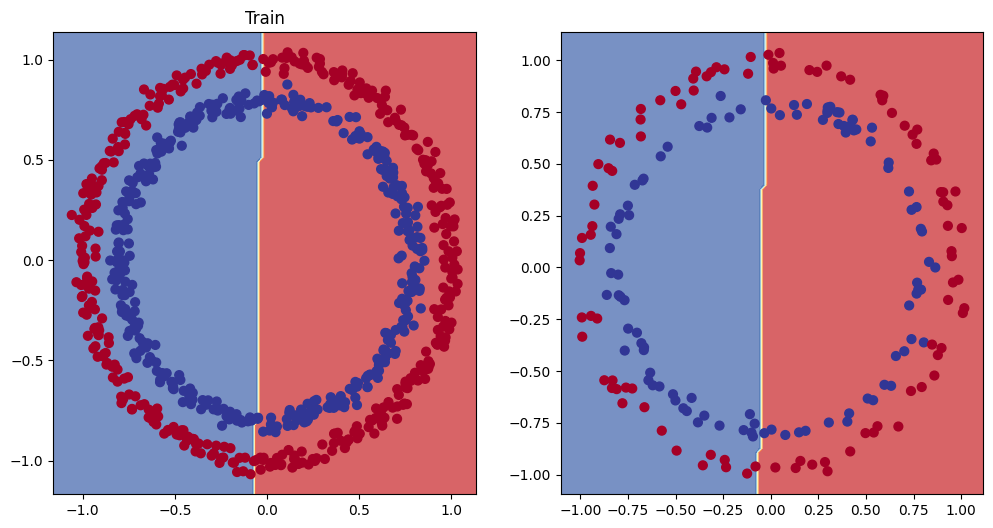

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

Focusing specifically on the model (not the data), there are a few ways we could do this.

| Model improvement technique* | What does it do? |
| ---------------------------- | ---------------- |
| **Add more layers** | Each layer *potentiaaly* increases the learning capabilitites of the model with each layer being able to learn some kind of new pattern in the data, more layers is often referred to as making your neural network deeper. |
| **Add more hidden units** | Similar to the above, more units per layer means a *potential* increase in learning capabilities of the model, more hidden units is often referred to as making your neural network *wider*. |
| **Fitting for longer (more epochs)** | Your model might learn more if it had more opportunities to look at the data. |
| **Changing the activation functions** | Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation function can help with this (hint, hint). |
| **Change the learning rate** | Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough. |
| **Change the loss function** | Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem. |
| **Use transfer learning** | Take a pretrained model from a problem domain similar to yours and adjust it to your own problem. We cover transfer learning in notebook 06. |

In [ ]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)  # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):  # note: alway make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [ ]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Define Loss function and Optimizer
# loss_fn = nn.BCELoss()  # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss()  # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)

epochs = 1000  # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))  # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_preds=y_preds)

    # 3. Optimizer zero gradient
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_preds=test_preds)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test Loss: 0.69261, Test Accuracy: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test Loss: 0.69379, Test Accuracy: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test Loss: 0.69437, Test Accuracy: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test Loss: 0.69458, Test Accuracy: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test Loss: 0.69465, Test Accuracy: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69467, Test Accuracy: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%


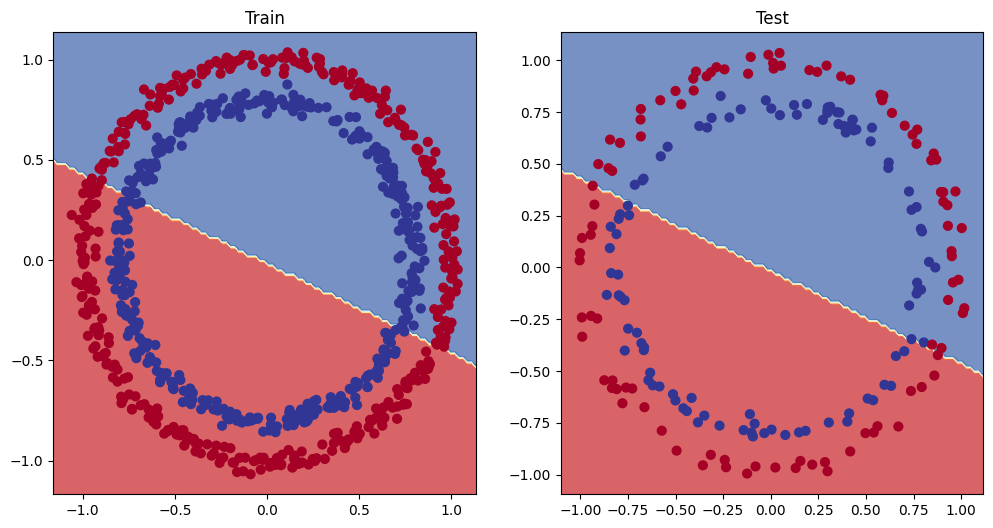

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can model a straight line

In [ ]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias  # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))  # 80% of data used for trainin set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
      len(y_train_regression),
      len(X_test_regression),
      len(y_train_regression))

80 80 20 80


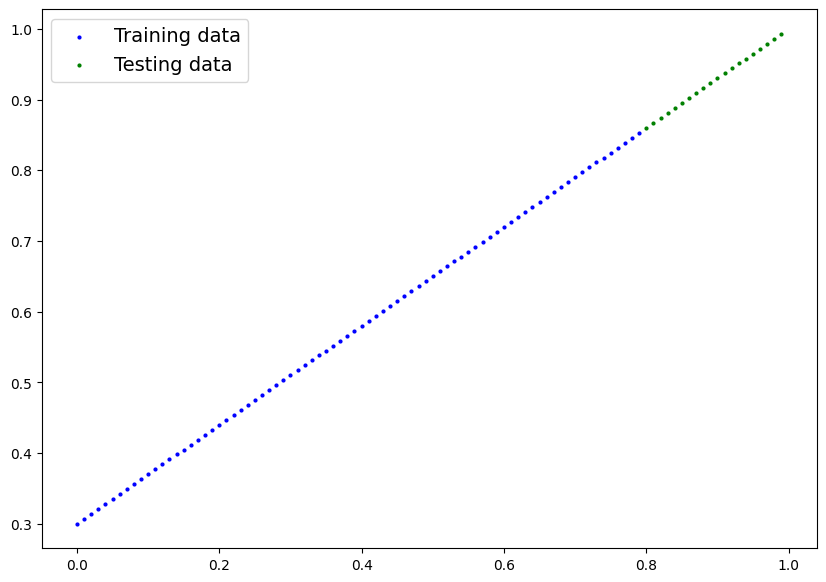

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting model_1 to fit a straght line

In [ ]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [ ]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

In [ ]:
## Create training function for the model
def train_fn(model, data, labels):
    model.train()
    # 1. Forward pass
    train_preds = model(data)

    # 2. Calculate the train loss (no accuracy since it's a regression problem, not classification)
    train_loss = loss_fn(train_preds, labels)

    # 3. Optimizer zero gradient
    optimizer.zero_grad()

    # 4. Loss backward()
    train_loss.backward()

    # 5. Optimizer step
    optimizer.step()

    return train_loss

## Create test function for the model
def test_fn(model, data, labels):
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_preds = model(data)

        # 2. Calculate the test loss
        test_loss = loss_fn(test_preds, labels)

    return test_loss

In [ ]:
for epoch in range(epochs):
    ### Training
    train_loss = train_fn(model_2, X_train_regression, y_train_regression)

    ### Testing
    test_loss = test_fn(model_2, X_test_regression, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}, Test Loss: {test_loss:.5f}")

Epoch: 0 | Train Loss: 0.39576, Test Loss: 0.16057
Epoch: 100 | Train Loss: 0.05579, Test Loss: 0.16672
Epoch: 200 | Train Loss: 0.05545, Test Loss: 0.14045
Epoch: 300 | Train Loss: 0.06213, Test Loss: 0.14600
Epoch: 400 | Train Loss: 0.05052, Test Loss: 0.13205
Epoch: 500 | Train Loss: 0.05542, Test Loss: 0.14467
Epoch: 600 | Train Loss: 0.07214, Test Loss: 0.12171
Epoch: 700 | Train Loss: 0.05617, Test Loss: 0.12099
Epoch: 800 | Train Loss: 0.06307, Test Loss: 0.11739
Epoch: 900 | Train Loss: 0.06094, Test Loss: 0.12716


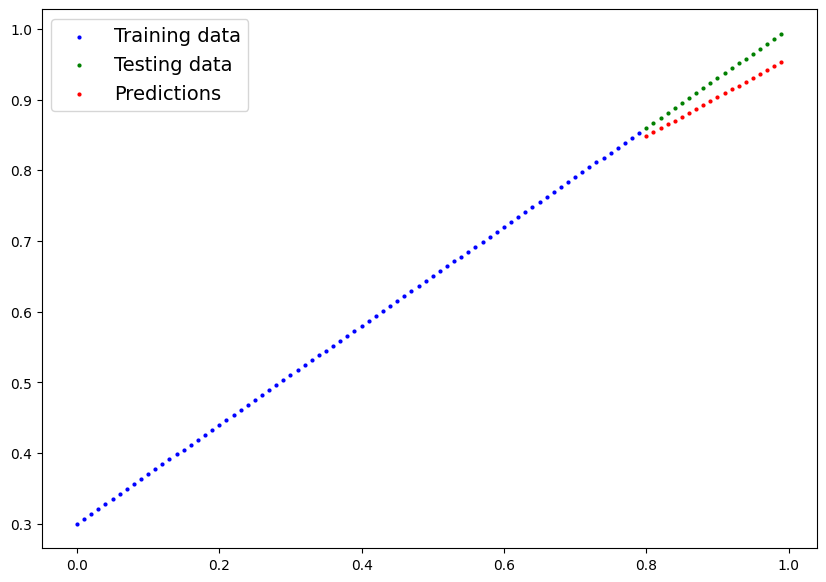

In [ ]:
# Turn on evaluation model
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing piece: non-linearity

### 6.1 Recreating non-linear data (red and blue circles)

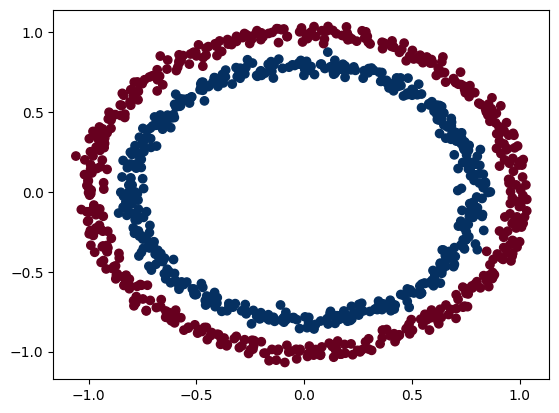

In [ ]:
# Make and plot data
n_samples = 1000

X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42,)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [ ]:
# Convert to tensors and split into train and test sets
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [ ]:
# Build model with non-linear activation function
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

        self.relu = nn.ReLU()  # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [ ]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [ ]:
### Create train function for the model
def train_fn(model, data, labels):
    # Change model to training
    model.train()
    # 1. Forward pass
    train_logits = model(data).squeeze()
    train_preds = torch.round(torch.sigmoid(train_logits))  # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    train_loss = loss_fn(train_logits, labels)  # BCEWithLogitsLoss calculates loss using logits
    train_acc = accuracy_fn(y_true=labels,
                            y_preds=train_preds)

    # 3. Optimizer zero gradient
    optimizer.zero_grad()

    # 4. Loss backward
    train_loss.backward()

    # 5. Optimizer step
    optimizer.step()

    return train_loss, train_acc

### Create test function for the model
def test_fn(model, data, labels):
    # Change mode to evaluation
    model.eval()
    # Activate inference mode for testing
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))  # logits -> prediction probabilities -> prediction labels

        # 2. Calculate loss and accuracy
        test_loss = loss_fn(test_logits, labels)
        test_acc = accuracy_fn(y_true=labels,
                               y_preds=test_preds)

    return test_loss, test_acc

In [ ]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    train_loss, train_acc = train_fn(model_3, X_train, y_train)
    ### Testing
    test_loss, test_acc = test_fn(model_3, X_test, y_test)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


### 6.4 Evaluating a model trained with non-linear activation functions

In [ ]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y[:10]  # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

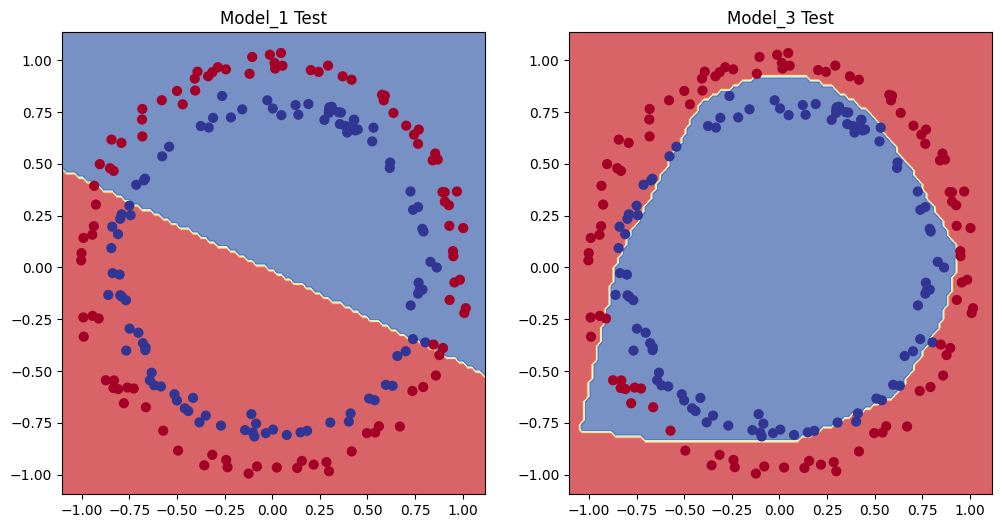

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Model_1 Test")
plot_decision_boundary(model_1, X_test, y_test)  # model_1 = n non-linearity
plt.subplot(1, 2, 2)
plt.title("Model_3 Test")
plot_decision_boundary(model_3, X_test, y_test)  # model_3 = has non-linearity

## 7. Replicating non-linear activation functions

In [ ]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

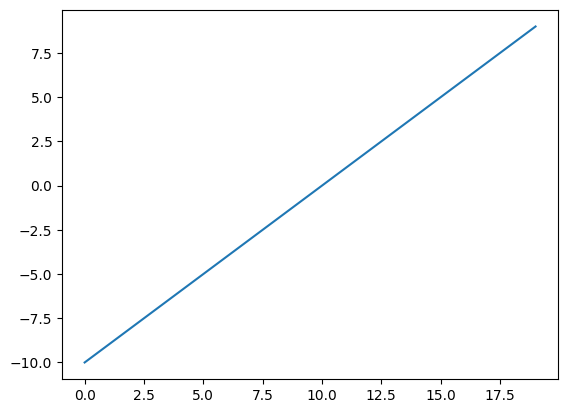

In [ ]:
# Visualise the toy tensor
plt.plot(A)

In [ ]:
# Create ReLU function by hand
def relu(x):
    return torch.maximum(torch.tensor(0), x)  # inputs must be tensors

In [ ]:
# Go through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

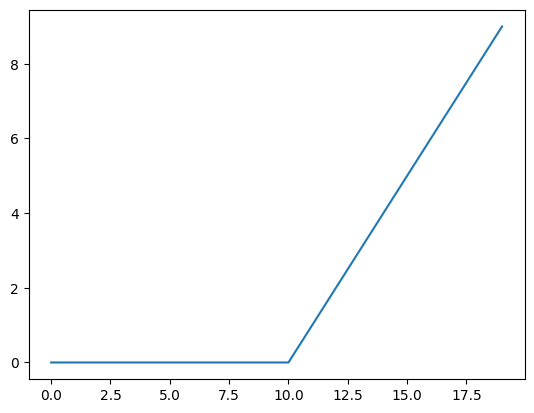

In [ ]:
# Plot ReLU activated toy tensor
plt.plot(relu(A))

In [ ]:
# Create a custom sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

In [ ]:
# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

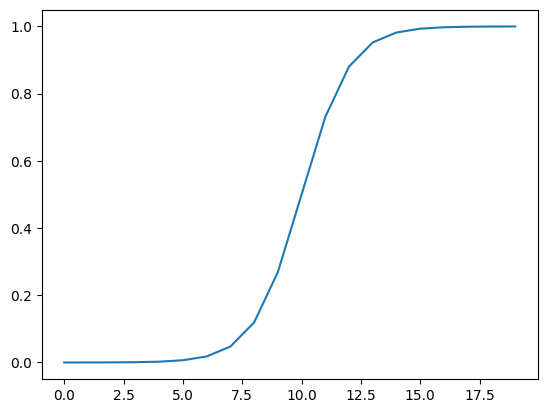

In [ ]:
# Plot simgoid activated toy tensor
plt.plot(sigmoid(A))

## 8. Putting things together by building a multi-class PyTorch model

Examples of **binary classification** and **multi-class classification** problems.
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-binary-vs-multi-class-classification.png)

### 8.1 Creating multi-class classification data

Specifically, let's do the following:
1. Create some multi-class data with `make_blobs()`.
2. Turn the data into tensors (the default of `make_blobs()` is to use NumPy arrays).
3. Split the data into training and test sets using `train_test_split()`.
4. Visualize the data.

In [ ]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [ ]:
# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,  # X features
                            centers = NUM_CLASSES,  # y labels
                            cluster_std=1.5,  # give the clusters a little shake up (try changing this to 1.0, the default)
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


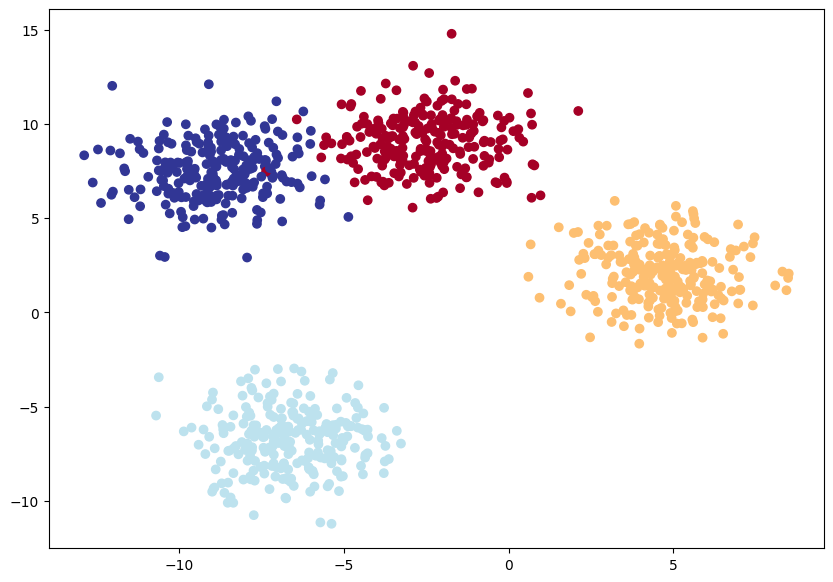

In [ ]:
# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Build model
class BlobModel(nn.Module):
    def __init__(self,
                 input_features: int,
                 output_features: int,
                 hidden_units: int = 8):
        """
        Inintializes all required hyperparameters for a multi-class
        classification model.
        :param input_features: Number of input features to the model;
        :param output_features: Number of output features of the model;
        :param hidden_units: Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),  # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [ ]:
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Creating a loss function and optimizer for a multi-class PyTorch model

In [ ]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)  # exercise: try changing the learning rate here
                                     # and seeing what happens to model's performance

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In [ ]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 1.9129,  0.8585, -0.4892, -0.2944],
        [ 0.6975, -1.1522,  1.6901, -0.4935],
        [-2.4454, -0.9268,  0.3074,  0.0853],
        [-1.4226, -0.7748,  0.4659, -0.0576],
        [ 0.3111, -1.1204,  1.5148, -0.4215]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [ ]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 1.9368,  0.6941, -0.2682, -0.3316],
        [-0.8163, -2.0296,  2.2997, -0.4134],
        [-1.8057, -0.5662,  0.0630,  0.0494],
        [ 1.3922,  0.7479, -0.5268, -0.2284],
        [ 1.3424, -0.7020,  1.3316, -0.5122]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.6656, 0.1921, 0.0734, 0.0689],
        [0.0394, 0.0117, 0.8898, 0.0590],
        [0.0577, 0.1993, 0.3740, 0.3689],
        [0.5349, 0.2808, 0.0785, 0.1058],
        [0.4395, 0.0569, 0.4348, 0.0688]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [ ]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.6656, 0.1921, 0.0734, 0.0689], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(0, device='cuda:0')


### 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [ ]:
# Set seed for reproduciability
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

In [ ]:
# Fit the model
for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train)  # model outputs raw logits
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)  # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_preds=y_preds)

    # 3. Optimizer zero gradient
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_preds=test_preds)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.66614, Accuracy: 20.88% | Test Loss: 0.54689, Test Accuracy: 60.50%
Epoch: 10 | Loss: 0.13644, Accuracy: 99.12% | Test Loss: 0.11919, Test Accuracy: 99.00%
Epoch: 20 | Loss: 0.08093, Accuracy: 99.00% | Test Loss: 0.07137, Test Accuracy: 99.50%
Epoch: 30 | Loss: 0.06113, Accuracy: 99.00% | Test Loss: 0.05281, Test Accuracy: 99.50%
Epoch: 40 | Loss: 0.05114, Accuracy: 99.00% | Test Loss: 0.04307, Test Accuracy: 99.50%
Epoch: 50 | Loss: 0.04521, Accuracy: 99.00% | Test Loss: 0.03712, Test Accuracy: 99.50%
Epoch: 60 | Loss: 0.04132, Accuracy: 99.00% | Test Loss: 0.03313, Test Accuracy: 99.50%
Epoch: 70 | Loss: 0.03860, Accuracy: 99.12% | Test Loss: 0.03027, Test Accuracy: 99.50%
Epoch: 80 | Loss: 0.03659, Accuracy: 99.12% | Test Loss: 0.02813, Test Accuracy: 99.50%
Epoch: 90 | Loss: 0.03506, Accuracy: 99.12% | Test Loss: 0.02646, Test Accuracy: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  8.0448,  13.6026,  -9.1395,  -5.2279],
        [  2.4588, -13.4441,   0.2879,   8.1163],
        [-12.7855, -19.7606,  15.4582,   6.6589],
        [  3.7282,   9.0784,  -4.4159,  -4.1055],
        [ 11.2191,   6.6382, -11.0033,  -0.2783],
        [  2.4075, -16.7506,   0.8529,   9.9549],
        [-12.4054, -16.0805,  14.5289,   4.7186],
        [  8.6392,   1.2469,  -7.7598,   1.9005],
        [-14.3235, -26.1795,  17.8930,   9.7562],
        [  9.4057,   3.1606,  -8.7723,   1.0782]], device='cuda:0')

In [ ]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_blob_test, y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


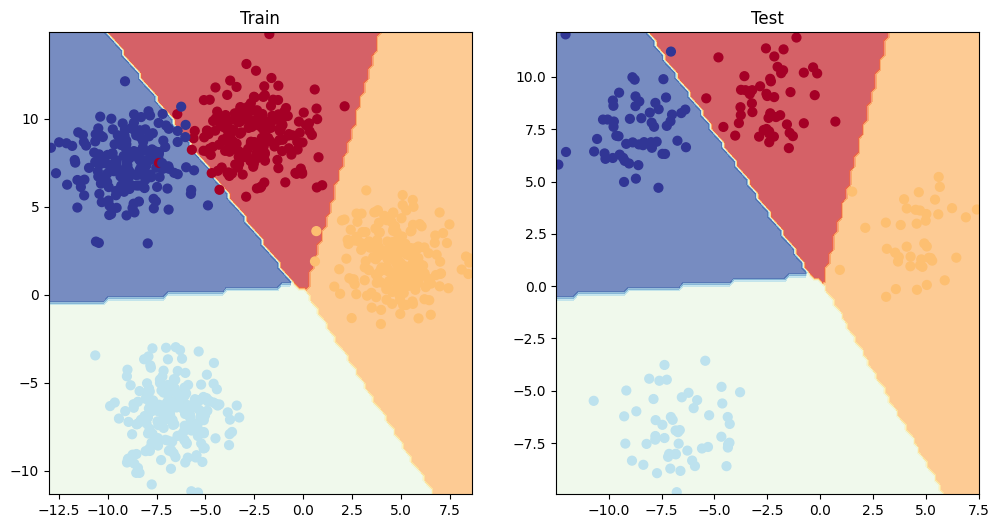

In [ ]:
# Plot predictions with `plot_decision_boundary()`
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. More classification evaluation metrics

However, you may want to evaluate your classification model using more metrics such as the following:

| Metric name/Evaluation method | Definition | Code |
| ----------------------------- | ---------- | ---- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | `torchmetrics.Accuracy()` or `sklearn.metrics.accuracy_score()` |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | `torchmetrics.Precision()` or `sklearn.metrics.precision_score()` |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predictions 0 when it should've been 1). Higher recall leads to less false negatives. | `torchmetrics.Recall()` or `sklearn.metrics.recall_score()` |
| F1-score | Combines precision and recall into one metric 1 is best, 0 is worst. | `torchmetrics.F1Score()` or `sklearn.metrics.f1_score()` |
| Confusion matrix | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | `torhcmetrics.ConfusionMatrix` or `sklearn.metrics.plot_confusion_matrix()` |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | `sklearn.metrics.classification_report()` |

In [5]:
try:
    from torchmetrics import Accuracy
except:
        !pip install -q torchmetrics==0.11.4
        from torchmetrics import Accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 16.4 MB/s eta 0:00:00


In [ ]:
# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

## Exercises

In [6]:
# Make device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

### Exercise - 1

In [7]:
from sklearn.datasets import make_moons

# Define parameters for dataset
num_samples = 1000
rand_state = 42

In [8]:
# Build dataset with sklearn.make_moon()
X, y = make_moons(num_samples,
                  noise=0.02,
                  random_state=rand_state)
print(X.shape, y.shape)
X[:10], y[:10]

(1000, 2) (1000,)


(array([[-0.00331218,  0.38337854],
        [ 0.94351058, -0.48147221],
        [ 0.92575899, -0.44953496],
        [ 0.43047045, -0.3660583 ],
        [-0.84701745,  0.52790514],
        [ 0.57466205, -0.36878002],
        [ 0.29608277, -0.21037497],
        [-0.00854288,  0.43001282],
        [ 1.62969516, -0.27801685],
        [ 0.66616284,  0.77607306]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [9]:
# Convert to PyTorch tensors
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)
X[:10], y[:10]

(tensor([[-0.0033,  0.3834],
         [ 0.9435, -0.4815],
         [ 0.9258, -0.4495],
         [ 0.4305, -0.3661],
         [-0.8470,  0.5279],
         [ 0.5747, -0.3688],
         [ 0.2961, -0.2104],
         [-0.0085,  0.4300],
         [ 1.6297, -0.2780],
         [ 0.6662,  0.7761]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [10]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=rand_state)

### Exercise - 2

In [11]:
# Build model with non-linear activation function ReLU for data from exercise-1
class MoonsModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 15)
        self.layer_2 = nn.Linear(15, 15)
        self.layer_3 = nn.Linear(15, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [12]:
# Define model object
moons_model = MoonsModelV0().to(device)
moons_model

MoonsModelV0(
  (layer_1): Linear(in_features=2, out_features=15, bias=True)
  (layer_2): Linear(in_features=15, out_features=15, bias=True)
  (layer_3): Linear(in_features=15, out_features=1, bias=True)
  (relu): ReLU()
)

### Exercise - 3

In [13]:
# Define binary classification compatible loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(moons_model.parameters(), lr=0.2)
# Define PyTorch metric function for calculating accuracy of model
torch_accuracy = Accuracy(task="binary", num_classes=2).to(device)

### Exercise - 4


In [14]:
# Build training and testing functions
def train_part(model, data, labels):
    # Turn model to train mode
    model.train()

    # Forward pass
    y_logits = model(data).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # Calculate loss/accuracy
    train_loss = loss_fn(y_logits,
                         labels)
    train_acc = torch_accuracy(y_preds,
                               labels)

    # Optimizer zero gradient
    optimizer.zero_grad()

    # Loss backwards
    train_loss.backward()

    # Optimizer step
    optimizer.step()

    return train_loss, train_acc * 100

def test_part(model, data, labels):
    # Turn model to evaluation mode
    model.eval()
    # Turn model to inference mode
    with torch.inference_mode():
        # Forward pass
        test_logits = model(data).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        # Calculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            labels)
        test_acc = torch_accuracy(test_preds,
                                  labels)

    return test_loss, test_acc * 100

In [15]:
epochs = 300

# Turn data to certain device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Go through loop
for epoch in range(epochs):
    ### Training
    train_loss, train_accuracy = train_part(moons_model, X_train, y_train)

    ### Testing
    test_loss, test_accuracy = test_part(moons_model, X_test, y_test)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0 or epoch == epochs - 1:
        if epoch == epochs - 1:
            print("Last Epoch:")
        print(f"Epoch: {epoch} | Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}% | " +
                                 f"Test_Loss: {test_loss:.4f}, Test_Accuracy: {test_accuracy:.2f}%")

Epoch: 0 | Loss: 0.6841, Accuracy: 50.00% | Test_Loss: 0.6768, Test_Accuracy: 50.00%
Epoch: 10 | Loss: 0.6219, Accuracy: 83.25% | Test_Loss: 0.6178, Test_Accuracy: 84.50%
Epoch: 20 | Loss: 0.5251, Accuracy: 84.50% | Test_Loss: 0.5217, Test_Accuracy: 85.00%
Epoch: 30 | Loss: 0.3991, Accuracy: 85.12% | Test_Loss: 0.4001, Test_Accuracy: 85.50%
Epoch: 40 | Loss: 0.3180, Accuracy: 86.00% | Test_Loss: 0.3223, Test_Accuracy: 87.00%
Epoch: 50 | Loss: 0.2780, Accuracy: 86.88% | Test_Loss: 0.2809, Test_Accuracy: 88.50%
Epoch: 60 | Loss: 0.2550, Accuracy: 88.62% | Test_Loss: 0.2556, Test_Accuracy: 89.50%
Epoch: 70 | Loss: 0.2401, Accuracy: 88.88% | Test_Loss: 0.2389, Test_Accuracy: 90.50%
Epoch: 80 | Loss: 0.2300, Accuracy: 89.38% | Test_Loss: 0.2277, Test_Accuracy: 90.50%
Epoch: 90 | Loss: 0.2231, Accuracy: 89.62% | Test_Loss: 0.2196, Test_Accuracy: 91.00%
Epoch: 100 | Loss: 0.2173, Accuracy: 89.75% | Test_Loss: 0.2129, Test_Accuracy: 91.00%
Epoch: 110 | Loss: 0.2118, Accuracy: 90.12% | Test_Los

### Exercise - 5

In [16]:
# Making prediction with trained model
moons_model.eval()
with torch.inference_mode():
    test_logits = moons_model(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
test_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

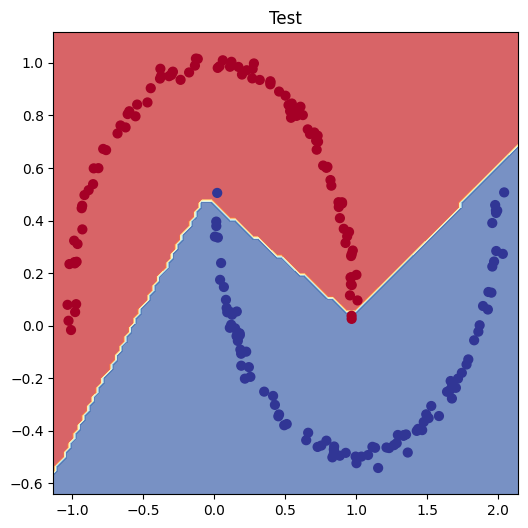

In [17]:
# Visualize predicitons with plot decision boundary
plt.figure(figsize=(6, 6))
plt.title("Test")
plot_decision_boundary(moons_model, X_test, y_test)

### Exercise - 6

In [18]:
# Build "hyperbolic tangent" activation function in pure PyTorch
def act_tanh(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

### Exercise - 7

In [19]:
import numpy as np
rand_state = 42

In [55]:
N = 100  # number of points per class
D = 2  # dimensionality (num features)
K = 3  # number of classes
X = np.zeros((N*K, D))  # data matrix (each row = single example)
y = np.zeros(N*K, dtype="uint8")  # class labels

for j in range(K):
    ix = range(N*j, N*(j+1))
    r = np.linspace(0.0, 1, N)  # radius
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2  # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

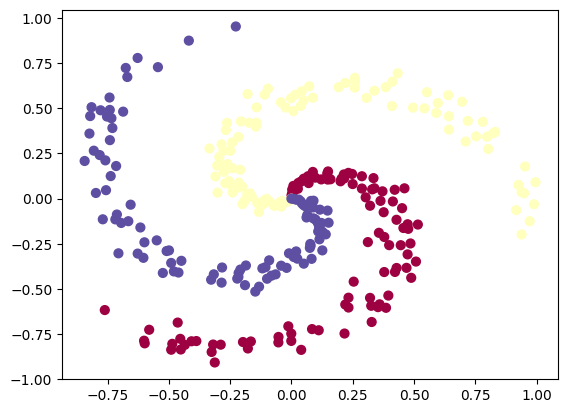

In [56]:
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

In [57]:
# Convert NumPy array to PyTorch tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [58]:
# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=rand_state)

In [59]:
# Recreate model with new activation function
class SpiralsModelV0(nn.Module):
    def __init__(self,
                 input_features:int,
                 output_features:int,
                 hidden_units: int = 8):
        """
        Initializes all required hyperparameters for a multi-class classfication model.

        :param input_features: Number of input features to the model;
        :param output_features: Number of output features of the model;
        :param hidden_units: Number of hidden units between layers, default 8;
        """
        super().__init__()
        self.layer_1 = nn.Linear(input_features, hidden_units)
        self.layer_2 = nn.Linear(hidden_units, hidden_units)
        self.layer_3 = nn.Linear(hidden_units, output_features)
        self.tanh_act = act_tanh

    def forward(self, x):
        return self.layer_3(self.tanh_act(self.layer_2(self.tanh_act(self.layer_1(x)))))

In [75]:
# Define new model for multi-classification
spirals_model = SpiralsModelV0(input_features=D,
                               output_features=K,
                               hidden_units=10).to(device)
spirals_model

SpiralsModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=3, bias=True)
)

In [76]:
# Build loss function and optimizer for multi-class data
loss_fn = nn.CrossEntropyLoss()
adam_opt = torch.optim.Adam(spirals_model.parameters(), lr=0.002)
torch_accuracy = Accuracy(task="multiclass", num_classes=K).to(device)

In [77]:
# Build training and testing functions for multi-class model
def train_fn(model, data, labels):
    # Turn model to train mode
    model.train()
    # Forward pass
    train_logits = model(data)
    train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)  # go from logits -> prediction probabilities -> prediction labels

    # Calculate loss and accuracy
    train_loss = loss_fn(train_logits, labels)
    train_acc = torch_accuracy(train_preds, labels)

    # Optimizer zero gradient
    adam_opt.zero_grad()

    # Loss backwards
    train_loss.backward()

    # Optimizer step
    adam_opt.step()

    return train_loss, train_acc * 100

def test_fn(model, data, labels):
    # Turn model to evaluation mode
    model.eval()
    # Turn model to inference mode for better performance
    with torch.inference_mode():
        # Forward pass
        test_logits = model(data)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, labels)
        test_acc = torch_accuracy(test_preds, labels)

    return test_loss, test_acc * 100

In [78]:
# Fit the model
torch.manual_seed(rand_state)

# Set number of epochs
epochs = 1000
# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [79]:
# Go through loop for training
for epoch in range(epochs):
    ### Training
    train_loss, train_acc = train_fn(spirals_model, X_train, y_train)
    ### Testing
    test_loss, test_acc = test_fn(spirals_model, X_test, y_test)

    # Print out what's happenning
    if epoch % 100 == 0 or epoch == epochs - 1:
        if epoch == epochs - 1:
            print("Last Epoch")
        print(f"Epoch: {epoch} | Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}% | " +
                                f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.0966, Accuracy: 32.50% | Test Loss: 1.0884, Test Accuracy: 36.67%
Epoch: 100 | Loss: 0.7684, Accuracy: 56.25% | Test Loss: 0.8311, Test Accuracy: 45.00%
Epoch: 200 | Loss: 0.6735, Accuracy: 56.67% | Test Loss: 0.7852, Test Accuracy: 50.00%
Epoch: 300 | Loss: 0.5372, Accuracy: 72.50% | Test Loss: 0.6656, Test Accuracy: 58.33%
Epoch: 400 | Loss: 0.3443, Accuracy: 85.83% | Test Loss: 0.4656, Test Accuracy: 85.00%
Epoch: 500 | Loss: 0.2390, Accuracy: 92.50% | Test Loss: 0.3731, Test Accuracy: 91.67%
Epoch: 600 | Loss: 0.1827, Accuracy: 94.17% | Test Loss: 0.3421, Test Accuracy: 91.67%
Epoch: 700 | Loss: 0.1457, Accuracy: 96.25% | Test Loss: 0.3315, Test Accuracy: 93.33%
Epoch: 800 | Loss: 0.1192, Accuracy: 97.08% | Test Loss: 0.3228, Test Accuracy: 95.00%
Epoch: 900 | Loss: 0.0990, Accuracy: 97.92% | Test Loss: 0.3141, Test Accuracy: 96.67%
Last Epoch
Epoch: 999 | Loss: 0.0837, Accuracy: 99.17% | Test Loss: 0.3076, Test Accuracy: 96.67%


In [80]:
# Making predictions with trained model
spirals_model.eval()
with torch.inference_mode():
    test_logits = spirals_model(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
test_preds[:10], y_test[:10]

(tensor([2, 2, 1, 0, 2, 2, 1, 1, 0, 1], device='cuda:0'),
 tensor([2, 2, 1, 0, 2, 2, 1, 1, 0, 1], device='cuda:0'))

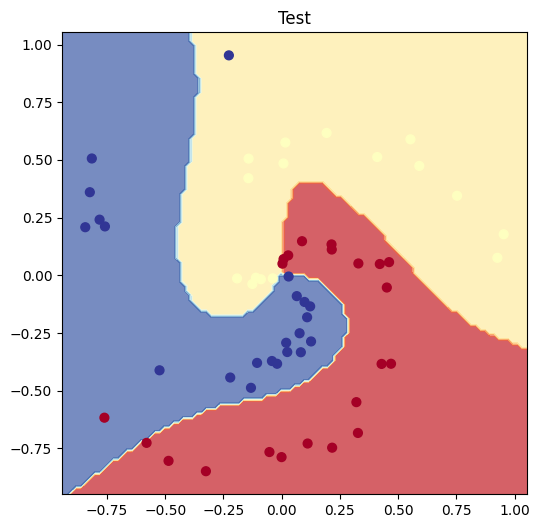

In [81]:
# Visualise predictions with plot decision boundary
plt.figure(figsize=(6, 6))
plt.title("Test")
plot_decision_boundary(spirals_model, X_test, y_test)

## Extra-curriculum

### 1. Problems where machine learning classification could be useful
I think it could be useful in:
- classifying user activities on the webpage as robot activities or not based on the time per click and time view per page (features).
- classifying fish disease on fish farms to cultivate the healthiest fish for food, based on fish skin and fish eyes (features).
- classifying the type of customers and the type of products they take, to change the placement of products in the store, for more convenient access to them for different types of customers, based on some features from the video stream.